# Drug Recommendations Using DiSCoVER

This notebook performs RNASeq quantitation using Kallisto [1](#References) to then utilize the DiSCoVER algorithm [2](#References) identify therapeutics which target the specific disease sample provided.

In [9]:
# Requires GenePattern Notebook: pip install genepattern-notebook
import gp
import genepattern

# Username and password removed for security reasons.
genepattern.display(genepattern.session.register("https://cloud.genepattern.org/gp", "", ""))

GPAuthWidget()

# Run Kallisto

<div class="alert alert-info">
<h3 style="margin-top: 0;"> Instructions <i class="fa fa-info-circle"></i></h3>
  
Note that his implementation of Kallisto run  a human genome index.  
- Provide the FASTQ files in the corresponding parameter.  
- Provide any extra commands to pass to Kallisto (for paired end data, this is not necessary).  

If you are providing a large FASTQ file, make sure you request enough memory to process it. You can do this by clicking the gear icon (⚙︎▾), selecting Advanced Options, and choosing from the job memory drop down.
</div>

In [10]:
kallisto_task = gp.GPTask(genepattern.session.get(0), 'urn:lsid:broad.mit.edu:cancer.software.genepattern.module.analysis:00383')
kallisto_job_spec = kallisto_task.make_job_spec()
kallisto_job_spec.set_parameter("extra_commands", "")
kallisto_job_spec.set_parameter("fastq_files", ["https://datasets.genepattern.org/data/module_support_files/Kallisto/1552-GSC_S25_R1_001.fastq.gz", "https://datasets.genepattern.org/data/module_support_files/Kallisto/1552-GSC_S25_R2_001.fastq.gz"])
kallisto_job_spec.set_parameter("job.memory", "16Gb")
kallisto_job_spec.set_parameter("job.queue", "gpbeta-default")
kallisto_job_spec.set_parameter("job.cpuCount", "1")
kallisto_job_spec.set_parameter("job.walltime", "02:00:00")
genepattern.display(kallisto_task)

job123421 = gp.GPJob(genepattern.session.get(0), 123421)
genepattern.display(job123421)

GPTaskWidget(lsid='urn:lsid:broad.mit.edu:cancer.software.genepattern.module.analysis:00383')

GPJobWidget(job_number=123421)

# Run DiSCoVER

<div class="alert alert-info">
<h3 style="margin-top: 0;"> Instructions <i class="fa fa-info-circle"></i></h3>
    
- Provide the gene expression as a CSV file (if this is the output from Kallisto, you can choose it from the drop down menu).  
- Indicate whether this sample is classified as medulloblastoma.  
- Indicate if a file with the gene expression of the control sample will be provided.  
- Provide the control gene expression as a CSV file (if necessary).  
- Choose wether to display supplementary files.
</div>

In [11]:
discover_task = gp.GPTask(genepattern.session.get(0), 'urn:lsid:broad.mit.edu:cancer.software.genepattern.module.analysis:00393')
discover_job_spec = discover_task.make_job_spec()
discover_job_spec.set_parameter("gene_expression", "https://cloud.genepattern.org/gp/jobResults/123421/RNASeq_quant/gene_expression.csv")
discover_job_spec.set_parameter("is_medulloblastoma", "False")
discover_job_spec.set_parameter("use_custom_control", "False")
discover_job_spec.set_parameter("control", "")
discover_job_spec.set_parameter("output_supplementary_files", "False")
discover_job_spec.set_parameter("job.memory", "2 Gb")
discover_job_spec.set_parameter("job.queue", "gpbeta-default")
discover_job_spec.set_parameter("job.cpuCount", "1")
discover_job_spec.set_parameter("job.walltime", "02:00:00")
genepattern.display(discover_task)

job124045 = gp.GPJob(genepattern.session.get(0), 124045)
genepattern.display(job124045)

GPTaskWidget(lsid='urn:lsid:broad.mit.edu:cancer.software.genepattern.module.analysis:00393')

GPJobWidget(job_number=124045)

# Create Table

<div class="alert alert-info">
<h3 style="margin-top: 0;"> Instructions <i class="fa fa-info-circle"></i></h3>
  
- Select the CSV file that DiSCoVER outputs
- Indicate how many drugs to display
</div>

In [13]:
import pandas as pd
from io import StringIO
import nbtools
import numpy as np

##### Before DiSCoVER
def split_discover_dataframe(df, min_score=0):
    # This is super inefficient for larger DataFrames, but let's worry about efficiency later

    out = pd.DataFrame(columns=['moa','GDSC','CTRP','CCLE','drug'])

    for index, row in df.iterrows():
        dataset = row['drug'].split('_')[0].lower()
        drug = row['drug'].split('_')[1].lower()

        if dataset == 'gdsc':
            out.loc[drug,'GDSC'] = row['score']
        elif dataset == 'ctrp':
            out.loc[drug,'CTRP'] = row['score']
        elif dataset == 'ccle':
            out.loc[drug,'CCLE'] = row['score']
        out.loc[drug,'drug'] = row['drug']
        out.loc[drug,'moa'] = row['moa']

    #     df['database'] = [drug.split('_')[0].upper() for drug in df['drug']]
    #     df['drug'] = [drug.split('_')[1].lower() for drug in df['drug']]
    #     df = df[df['score']>0]  # It feels inneficient to do this last, but Pandas complaints if I do it earlier.
    #     out = df[~df['drug'].duplicated(keep='first')].drop('score', axis=1,inplace=False)
    #     out['Drug'] = np.unique([drug.split('_')[1].lower() for drug in df['drug']])
    return out

sign_to_letter = {
    1:"+",
    -1:"-",
    '1.0':"+",
    '-1.0':"-",
    'nan':'.',
    '0.0':'.',
    '0':'.',
    0:'.',
}

annotation = {
    "motesanib":"VEGFR inhibitor, receptor tyrosine kinase inhibitor, PDGFR inhibitor, Kit inhibitor, Ret receptors inhibitor, Cell proliferation inhibitor",
    'cetuximab':"EGFR inhibitor",
    'gw-2580':"Tyrosine Kinase inhibitor",
    'dabrafenib':'BRAF inhibitor',
    'cyclopamine':'glioma-associated oncogene inhibitor',
    'rucaparib':'PARP inhibitor',
    'plx-4720':'BRAF inhibitor',
}

def supporting_evidence(row):
    # assuming only three columns
    return sign_to_letter[str(np.sign(row[0]))]+sign_to_letter[str(np.sign(row[1]))]+sign_to_letter[str(np.sign(row[2]))]


def rank_drugs_discover(df):
    df['score'] = df.drop(['moa','drug'],axis=1,inplace=False).mean(axis=1,skipna=True).round(3)
    df['evidence'] = df.drop(['moa','score'],axis=1).apply(supporting_evidence, axis=1)
    return df.sort_values(by=['score'],ascending=False,axis=0)

def make_clickable(url):
    to_display = url.split('=')[1]
    return '<a href="{}" target="_blank">{}</a>'.format(url, to_display)



@nbtools.build_ui(
        name="Make drug table",
        description='Create an easy to read table based on the output from DiSCoVER.',
        parameters={
                    "GP_csv": {  "name": "DiSCoVER output CSV file",
                                 "type": "file",
                                 "kinds": ["csv","CSV"],
                                 "description":"The output from DiSCoVER",
                            },
                   "number_of_drugs": {"default":10},
                   "output_var": {"default":"drug_df"},
                })
def make_table(GP_csv:'URL of the CSV output from DiSCoVER',
               number_of_drugs:'How many drugs to report'=10,
              ):
    uio = nbtools.UIOutput(name='Example Output',status='Running!')
    
    uio.status = 'Fetching csv file...'
    # Get the job number and name of the file
    temp = GP_csv.split('/')
    # programatically access that job to open the file
    GP_csv = eval('job'+temp[5]+'.get_file("'+temp[6]+'")')
    drug_df = pd.read_csv(StringIO(GP_csv.read()),index_col=0)
    drug_df['drug'] = drug_df.index

    df = split_discover_dataframe(df=drug_df)
    df = rank_drugs_discover(df)
    df['Pubchem link']=pd.Series(["https://pubchem.ncbi.nlm.nih.gov/#query={}".format(drug) for drug in df.index.values], index=df.index)
    df['Manual annotation']=pd.Series([annotation[drug] if drug in annotation.keys() else 'N/A' for drug in df.index.values], index=df.index)
    
    annotation
    styled_df = df.head(number_of_drugs).style.format({'Pubchem link': make_clickable})
    
    uio.status = 'Formatting csv file...'
    display(styled_df)
    return df

UIBuilder(description='Create an easy to read table based on the output from DiSCoVER.', function_import='make…

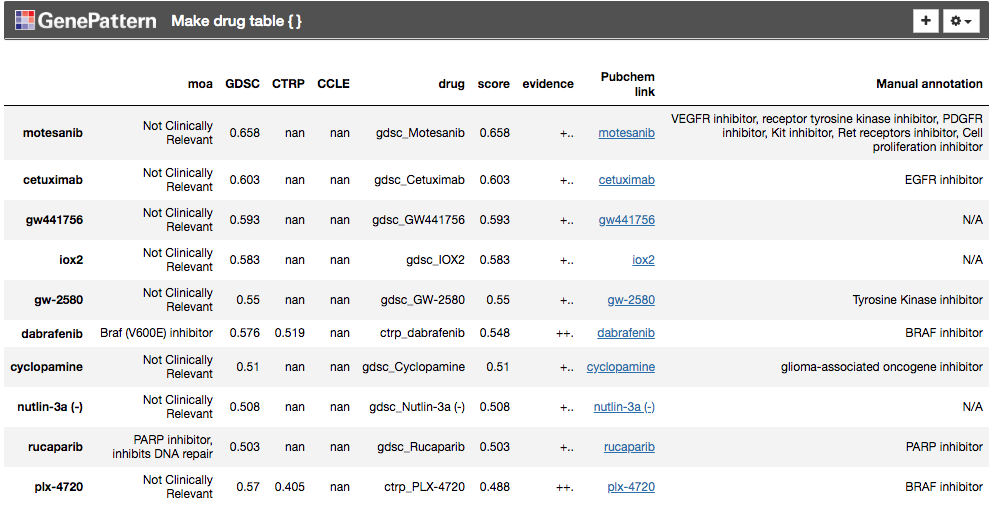

# References

1. https://pachterlab.github.io/kallisto/manual

1. Hanaford, A. R., Archer, T. C., Price, A., Kahlert, U. D., Maciaczyk, J., Nikkhah, G., … Raabe, E. H. (2016). DiSCoVERing Innovative Therapies for Rare Tumors: Combining Genetically Accurate Disease Models with In Silico Analysis to Identify Novel Therapeutic Targets. Clinical cancer research : an official journal of the American Association for Cancer Research, 22(15), 3903–3914. doi:10.1158/1078-0432.CCR-15-3011